# Training PathTST on SW drivers

> Based on tsai's implementation

In [2]:
import sklearn
from tsai.basics import *
from swdf.utils import *
my_setup(sklearn)
from matplotlib import dates as mdates
import wandb
from fastai.callback.wandb import WandbCallback

os              : Linux-5.14.0-1058-oem-x86_64-with-glibc2.31
python          : 3.9.2
tsai            : 0.3.6
fastai          : 2.7.11
fastcore        : 1.5.28
sklearn         : 1.2.2
torch           : 1.13.1+cu117
cpu cores       : 4
threads per cpu : 2
RAM             : 15.32 GB
GPU memory      : N/A


Some hints about hyperparameters:
- According to the authors of PathTST: "The ideal patch length may depend on the dataset, 
but P between {8, 16} seems to be general good numbers."

In [5]:
config = AttrDict(
    arch_config = AttrDict(
        n_layers=3,  # number of encoder layers
        n_heads=4,  # number of heads
        d_model=16,  # dimension of model
        d_ff=128,  # dimension of fully connected network
        attn_dropout=0.0, # dropout applied to the attention weights
        dropout=0.3,  # dropout applied to all linear layers in the encoder except q,k&v projections
        patch_len=9,  # length of the patch applied to the time series to create patches. 
        stride=1,  # stride used when creating patches
        padding_patch=True,  # padding_patch
    ),
    bs = 16, # Batch size
    data_source = 'https://sol.spacenvironment.net/jb2008/indices/SOLFSMY.TXT',
    n_epoch = 10, # Number of epochs to train for
    lookback = 36, # six times the horizon, as in Stevenson et al. (2021)
    horizon = 6, # same as paper by Licata et al. (2020)
    use_wandb = False, # To use it, the environment variable WANDB_API_KEY must be set
    wandb_project = 'swdf', # Name of wandb project
)

In [6]:
run = wandb.init(project=config.wandb_project, 
                 config=config, 
                 anonymous='never') if config.use_wandb else None
config = run.config if config.use_wandb else config

In [7]:
data_path = download_data(config.data_source)
data_path

Path('/home/vscode/.fastai/archive/SOLFSMY.TXT')

In [8]:
# Read the text file into a pandas DataFrame, ignoring the lines starting with '#'
# Column names: YYYY DDD   JulianDay  F10   F81c  S10   S81c  M10   M81c  Y10   Y81c  Ssrc
df_raw = pd.read_csv(data_path, delim_whitespace=True, comment='#', header=None, 
                 names=['Year', 'DDD', 'JulianDay', 'F10', 'F81c', 'S10', 'S81c', 
                        'M10', 'M81c', 'Y10', 'Y81c', 'Ssrc'])
df_raw.head()

,Year,DDD,JulianDay,F10,F81c,S10,S81c,M10,M81c,Y10,Y81c,Ssrc
0,1997,1,2450450.0,72.4,78.0,74.0,79.2,65.4,73.8,61.9,70.7,1B11
1,1997,2,2450451.0,72.1,77.9,73.8,79.1,66.9,73.7,63.4,70.4,1B11
2,1997,3,2450452.0,73.3,77.6,75.0,79.1,70.1,73.6,64.9,70.2,1B11
3,1997,4,2450453.0,73.8,77.3,76.3,79.0,71.6,73.4,65.5,69.8,1B11
4,1997,5,2450454.0,74.4,76.9,77.6,78.9,72.4,73.3,66.7,69.6,1B11


F10, S10, M10, and Y10 (81c) have diffe_sfu_sfu_sfu_sfu_sfurent observation and report times; to standardize reporting, all values are reported in sfu units at 12UT (Universal Time); observations are 3-times daily for F10 (20 UT used), every 5 minutes for S10 (daily average used), twice daily for M10 (7 and 16 UT), and every 1 minute for Y10 (Xrays are each minute while Lya is daily); 

For model inputs the values should be used as a daily value between 0-24 UT for a given calendar date; F10 and S10 are 1-day lagged, M10 is 2-day, and Y10 is 5-day lagged in JB2008; the 81-day centered values are used with the same respective lag times. Ssrc has 4 fields (1 for each index): 

*  0 = (F10, S10, M10, Y10) spline-filled if value or missing if no value; 
* 1 = (F10, M10, Y10) derived or measured index, (S10) SOHO/SEM; 
* 2 = (S10) TIMED/SEE v11; 
* 3 = (S10) SOHO gap (daily); 
* 4 = (S10) SOHO gap (average); 
* 5 = (F10) F10 mean (2 surrounding values), (S10) SDO/EVE; 
* 6 = (S10) GOES/EUVS fill-in, (M10) M10 mean (2 surrounding values); 
* 7 = (S10) S10 scaled to match M10 change from previous day; 
* 8 = (S10) SDO/EVE corrections and all S10 tweaked from sat 12388 delta B%, (Y10) UARS/SOLSTICE V18; 
* 9 = (S10) replace original v4.0h data for versions 4.0 and higher, (Y10) UARS/SOLSTICE v19; 
* A = (S10) TIMED/SEE solar minimum correction; 
* B = (S10) replace with original v4.0h S10 data for versions 4.0 and higher, (M10) SORCE/SOLSTICE/SIM v9; 
* C = (S10) SDO/EVE correction, (Y10) GOES XRS; 
* D = (S10) validated TIMED/SEE, (Y10) GOES XRS and SET composite LYA; 
* E = (S10) S10 composite, (Y10) SET composite LYA; 
* F = (F10, S10, M10, Y10) mean of bordering values

Acronyms:
* SOHO/SEM: Solar and Heliospheric Observatory/ Spacecraft's Solar Extreme-ultraviolet Monitor (SEM)
* SDO/EVE: Solar Dynamics Observatory/Extreme Ultraviolet Variability Experiment.
* UARS/SOLSTICE: Upper Atmosphere Research Satellite/Solar Stellar Irradiance Comparison Experiment
* SORCE/SOLSTICE/SIM: Solar Radiation and Climate Experiment/SOLSTICE/Spectral Irradiance Monitor
* GOES/XRS: Geostationary Operational Environmental Satellite/X-Ray Sensor
* "SET composite LYA" refers to the solar irradiance in the Lyman-alpha (Lyα) wavelength range, as measured by the Solar EUV Experiment Telescope (SET) onboard the Solar Radiation and Climate Experiment (SORCE) spacecraft.

This webpage contains forecasts (paid forecast) that we can use to compare to
https://agupubs.onlinelibrary.wiley.com/doi/pdf/10.1029/2020SW002496. It's interesting
to see what they forecast from the previous data in order to try the same thing 
with the neural network

## Data preprocessing

In [9]:
# Check if there are any missing values
df_raw.isna().sum()

Year         0
DDD          0
JulianDay    0
F10          0
F81c         0
S10          0
S81c         0
M10          0
M81c         0
Y10          0
Y81c         0
Ssrc         0
dtype: int64

In [10]:
# Convert the JulianDay column to a datetime column, and set it as index
df_raw['Date'] = pd.to_datetime(df_raw['JulianDay'], unit='D', origin='julian')
df_raw['Date'].head()
df_raw.set_index('Date', inplace=True)

In [11]:
# Distinct value of the column Ssrc
df_raw.Ssrc.unique()

array(['1B11', '5B11', '1B61', '1F11', '1B1F', '1A11', '1A61', '5A11',
       '5A61', '1F61', '1811', '1511', '1C11', '1D11', '1E11', '1E10'],
      dtype=object)

In [12]:
# Separate the Ssrc columns into four colums, one for each character of the string,
# The names of the new columns will be SsrcF10, SsrcS10, SsrcM10, and SsrcY10,
# Cast the new columns into categories. Use a loop
for i, c in enumerate('F10 S10 M10 Y10'.split()):
    df_raw[f'Ssrc_{c}'] = df_raw['Ssrc'].str[i].astype('category')
df_raw[['Ssrc_F10', 'Ssrc_S10', 'Ssrc_M10', 'Ssrc_Y10']].head()


,Ssrc_F10,Ssrc_S10,Ssrc_M10,Ssrc_Y10
Date,,,,
1997-01-01 12:00:00,1,B,1,1
1997-01-02 12:00:00,1,B,1,1
1997-01-03 12:00:00,1,B,1,1
1997-01-04 12:00:00,1,B,1,1
1997-01-05 12:00:00,1,B,1,1


In [13]:
# See the categories of the column Ssrc_S10
df_raw.Ssrc_S10.cat.categories

Index(['5', '8', 'A', 'B', 'C', 'D', 'E', 'F'], dtype='object')

In [1]:
#| hide

# Plot the variable S10. The color of the line will be determined by the value of Ssrc_S10
fig, ax = plt.subplots(figsize=(20, 5))
ax.scatter(df_raw.index, df_raw.S10, c=df_raw.Ssrc_S10.cat.codes, cmap='tab10', s=10)
ax.xaxis.set_major_locator(mdates.YearLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
ax.set_xlabel('Year')
ax.set_ylabel('S10')
ax.set_title('S10 and Ssrc_S10')
# TODO: Add a legend

NameError: name 'plt' is not defined

TODO: How can we detected those anomalies between 1988 and 1999? Maybe the ones equal to zero

165


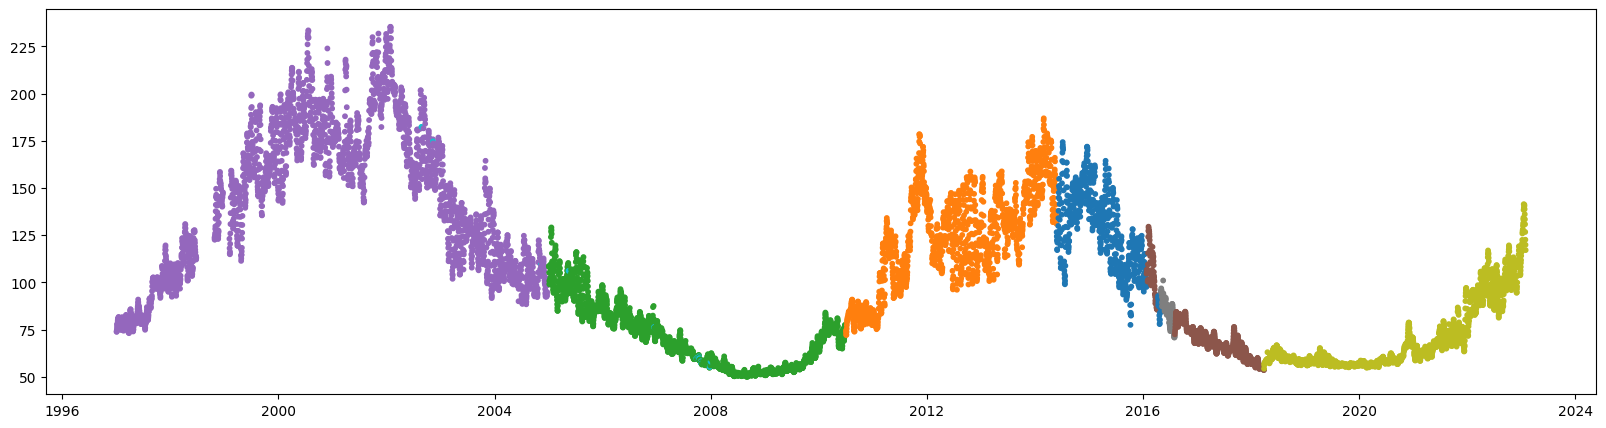

In [15]:
# Get the number of values equlas to zero in S10
print((df_raw.S10 == 0).sum())
# convert them to NA
df_raw.loc[df_raw.S10 == 0, 'S10'] = np.nan
# plot the variable S10 again
fig, ax = plt.subplots(figsize=(20, 5))
ax.scatter(df_raw.index, df_raw.S10, c=df_raw.Ssrc_S10.cat.codes, cmap='tab10', s=10)


In [16]:
datetime_col = 'Date'
freq = '1D'
data_columns = 'F10 S10 M10 Y10'.split()
imputation_method = 'ffill'

# sklearn's preprocessing pipeline
preproc_pipe = sklearn.pipeline.Pipeline([
    ('shrinker', TSShrinkDataFrame()), # shrik dataframe memory usage and set the right dtypes
    ('drop_duplicates', TSDropDuplicates(use_index=True)), # drop duplicates
    ('fill_missing', TSFillMissing(columns=data_columns, method=imputation_method, value=None)), # fill missing data (1st ffill. 2nd value=0)
], verbose=True)

df = preproc_pipe.fit_transform(df_raw)
df

Initial memory usage: 1005.32 KB
Final memory usage  : 494.39 KB  (-50.8%)
[Pipeline] .......... (step 1 of 3) Processing shrinker, total=   0.0s
[Pipeline] ... (step 2 of 3) Processing drop_duplicates, total=   0.0s
[Pipeline] ...... (step 3 of 3) Processing fill_missing, total=   0.0s


,Year,DDD,JulianDay,F10,F81c,S10,S81c,M10,M81c,Y10,Y81c,Ssrc,Ssrc_F10,Ssrc_S10,Ssrc_M10,Ssrc_Y10
Date,,,,,,,,,,,,,,,,
1997-01-01 12:00:00,1997,1,2450450.0,72.400002,78.000000,74.000000,79.199997,65.400002,73.800003,61.900002,70.699997,1B11,1,B,1,1
1997-01-02 12:00:00,1997,2,2450451.0,72.099998,77.900002,73.800003,79.099998,66.900002,73.699997,63.400002,70.400002,1B11,1,B,1,1
1997-01-03 12:00:00,1997,3,2450452.0,73.300003,77.599998,75.000000,79.099998,70.099998,73.599998,64.900002,70.199997,1B11,1,B,1,1
1997-01-04 12:00:00,1997,4,2450453.0,73.800003,77.300003,76.300003,79.000000,71.599998,73.400002,65.500000,69.800003,1B11,1,B,1,1
1997-01-05 12:00:00,1997,5,2450454.0,74.400002,76.900002,77.599998,78.900002,72.400002,73.300003,66.699997,69.599998,1B11,1,B,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-01-25 12:00:00,2023,25,2459970.0,166.500000,167.000000,130.800003,124.500000,181.000000,172.699997,177.699997,172.699997,1E11,1,E,1,1
2023-01-26 12:00:00,2023,26,2459971.0,146.000000,167.199997,126.699997,124.699997,166.199997,173.199997,166.899994,172.800003,1E11,1,E,1,1
2023-01-27 12:00:00,2023,27,2459972.0,140.500000,167.500000,122.599998,125.000000,155.300003,173.699997,164.899994,172.899994,1E11,1,E,1,1


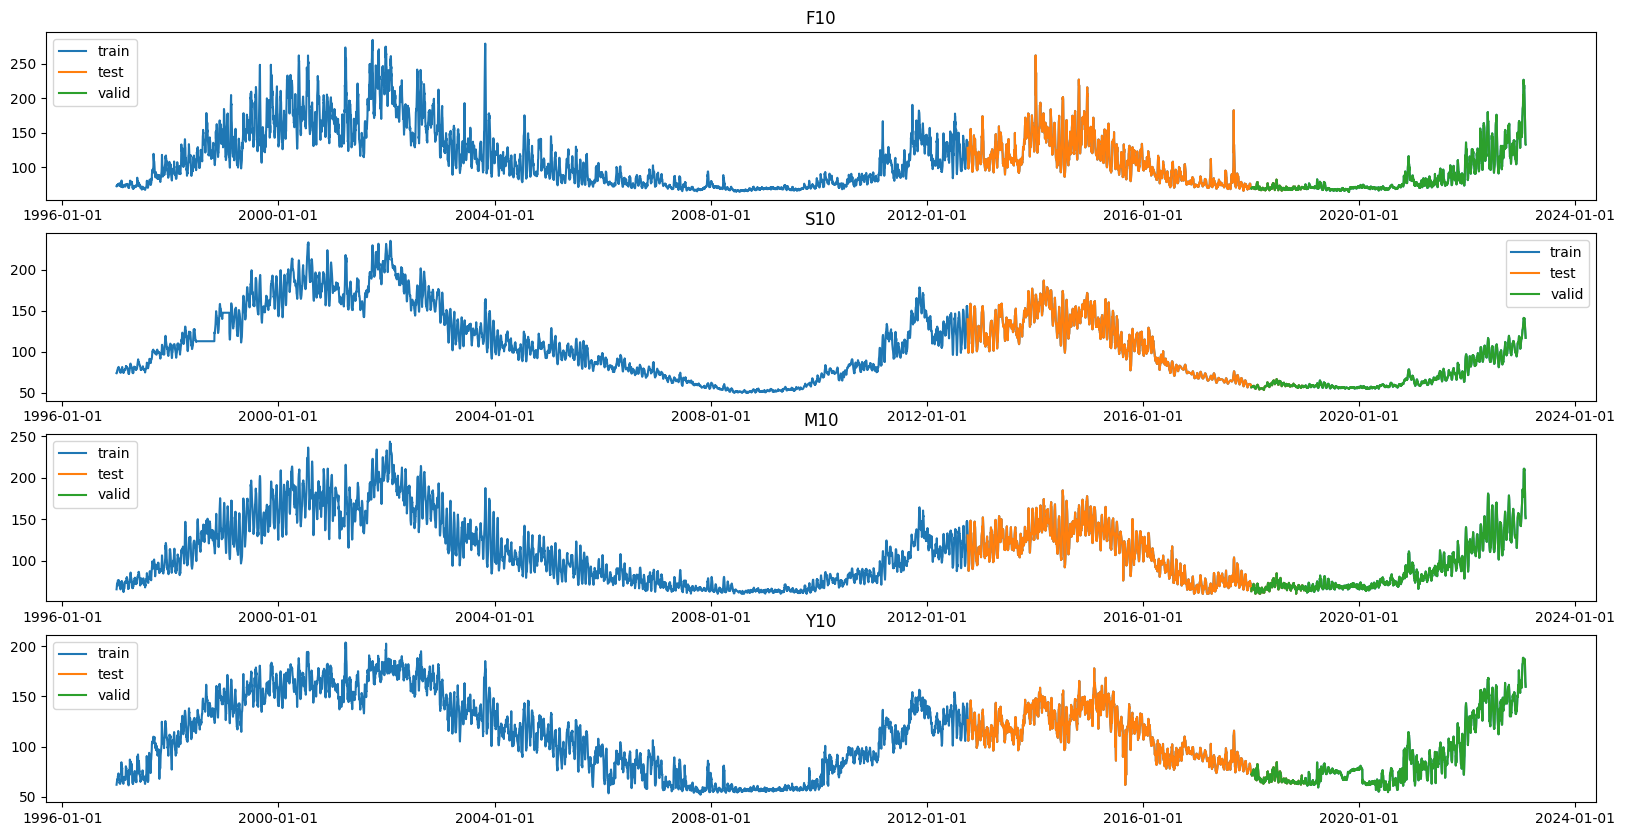

In [17]:
# In the paper by Licata et al. (2020) (https://agupubs.onlinelibrary.wiley.com/doi/pdf/10.1029/2020SW002496),
# authors use a period from October 2012 through the end of 2018 for the benchmarking.
# Therefore, we will set the test set as the same period for our analysis, 
# using the column Date as the timestamp, from October 2012 to the end of 2018. 
# Everything before the test set will be used for training, and everything after the test set
# will be used for validation
test_start_datetime = '2012-10-01'
test_end_datetime = '2018-12-31'
valid_start_datetime = '2018-01-01'


# Plot the variables F10, S10, M10 and Y10, covering the different periods (training, test and validation)
# with different colors. Do it for the 4 variables mentioned above 
fig, ax = plt.subplots(4, 1, figsize=(20, 10))
 
for i, var in enumerate(['F10', 'S10', 'M10', 'Y10']):
    ax[i].plot(df[var], label='train')
    ax[i].plot(df[var][(df.index >= test_start_datetime) & (df.index <= test_end_datetime)],
               label='test')
    ax[i].plot(df[var][(df.index >= valid_start_datetime)], label='valid')
    ax[i].set_title(var)
    ax[i].legend()
    ax[i].xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d')) # format x-axis ticks


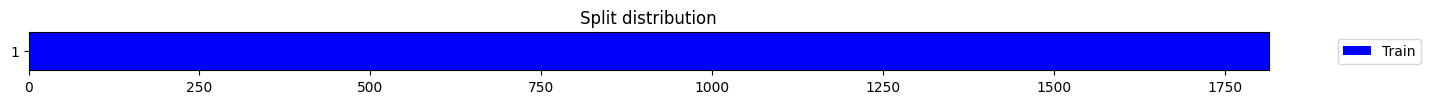

((#5712) [0,1,2,3,4,5,6,7,8,9...],
 (#1814) [7670,7671,7672,7673,7674,7675,7676,7677,7678,7679...],
 (#1912) [5717,5718,5719,5720,5721,5722,5723,5724,5725,5726...])

In [18]:
# Splits: Since the validation period is after the test period in this use case, we cannot
# use the default `get_forecasting_splits` from tsai. Instead, we will do manually
# the validation splits, and use the funcion only for the test splits

horizon = config.horizon 
lookback = config.lookback
#val_idxs = L(df.reset_index()[df.index >= valid_start_datetime].index.tolist())
splits_ = get_forecasting_splits(df[df.index < valid_start_datetime], 
                             fcst_history=lookback, 
                             fcst_horizon=horizon, 
                             use_index=True, 
                             test_cutoff_datetime=test_start_datetime, 
                             show_plot=False)
foo = df.reset_index()[df.index >= valid_start_datetime]
bar = get_forecasting_splits(foo, lookback, horizon, valid_size=0.0, test_size=0.0)
val_idxs = L(foo.index[bar[0]].tolist())

splits = (splits_[0], val_idxs, splits_[1])
splits

In [19]:
# Now that we have defined the splits for this particular experiment, we'll scaled
# the data
train_split = splits[0]
exp_pipe = sklearn.pipeline.Pipeline([
    ('scaler', TSStandardScaler(columns=data_columns)),
], verbose=True)
save_object(exp_pipe, 'tmp/exp_pipe.pkl')
exp_pipe = load_object('tmp/exp_pipe.pkl')

df_scaled = exp_pipe.fit_transform(df.reset_index(), scaler__idxs = train_split)
df_scaled.set_index(datetime_col, inplace=True)
df_scaled.head()

tmp directory already exists.
Pipeline saved as tmp/exp_pipe.pkl
[Pipeline] ............ (step 1 of 1) Processing scaler, total=   0.0s


,Year,DDD,JulianDay,F10,F81c,S10,S81c,M10,M81c,Y10,Y81c,Ssrc,Ssrc_F10,Ssrc_S10,Ssrc_M10,Ssrc_Y10
Date,,,,,,,,,,,,,,,,
1997-01-01 12:00:00,1997,1,2450450.0,-0.920213,78.000000,-0.861723,79.199997,-1.087715,73.800003,-1.266118,70.699997,1B11,1,B,1,1
1997-01-02 12:00:00,1997,2,2450451.0,-0.926854,77.900002,-0.866132,79.099998,-1.052542,73.699997,-1.228596,70.400002,1B11,1,B,1,1
1997-01-03 12:00:00,1997,3,2450452.0,-0.900291,77.599998,-0.839675,79.099998,-0.977507,73.599998,-1.191074,70.199997,1B11,1,B,1,1
1997-01-04 12:00:00,1997,4,2450453.0,-0.889222,77.300003,-0.811014,79.000000,-0.942334,73.400002,-1.176065,69.800003,1B11,1,B,1,1
1997-01-05 12:00:00,1997,5,2450454.0,-0.875940,76.900002,-0.782353,78.900002,-0.923576,73.300003,-1.146048,69.599998,1B11,1,B,1,1


 ### Apply a sliding window. 

In [20]:
# We'll approach the time series forecasting task as a supervised learning problem. 
# Remember that tsai requires that both inputs and outputs have the following shape:
# (samples, features, steps)

# To get those inputs and outputs we're going to use a function called 
# `prepare_forecasting_data`` that applies a sliding window along the dataframe:
x_vars = data_columns
y_vars = data_columns
X, y = prepare_forecasting_data(df, fcst_history=lookback, fcst_horizon=horizon, 
                                x_vars=x_vars, y_vars=y_vars)
X.shape, y.shape

((9484, 4, 36), (9484, 4, 6))

### Prepare the forecaster

#params: 19601


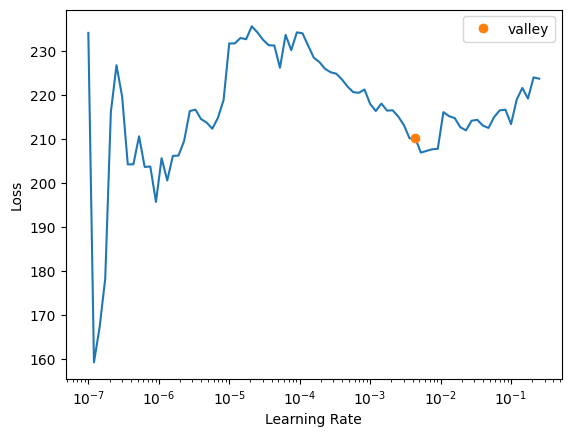

In [21]:
cbs = L(WandbCallback(log_preds=False)) if config.use_wandb else L()
learn = TSForecaster(X, y, splits=splits, batch_size=config.bs, path="models", 
                     pipelines=[preproc_pipe, exp_pipe], arch="PatchTST", 
                     arch_config=dict(config.arch_config), metrics=[mse, mae], 
                     cbs= cbs + ShowGraph())
lr_max = learn.lr_find().valley
print(f"#params: {sum(p.numel() for p in learn.model.parameters())}")

### Train

epoch,train_loss,valid_loss,mse,mae,time
0,99.104050,34.699280,34.699280,3.464530,00:09
1,86.829277,34.907791,34.907791,3.535805,00:10
2,85.821182,34.411953,34.411953,3.416343,00:11
3,86.954575,33.479172,33.479172,3.395235,00:10
4,89.084061,33.525562,33.525562,3.426555,00:10
5,79.026749,32.107838,32.107838,3.311060,00:10
6,80.529289,32.073349,32.073349,3.299736,00:10
7,79.142731,31.503691,31.503691,3.286891,00:11
8,72.375114,31.453831,31.453831,3.259248,00:11
9,71.875511,31.123960,31.123960,3.242939,00:11


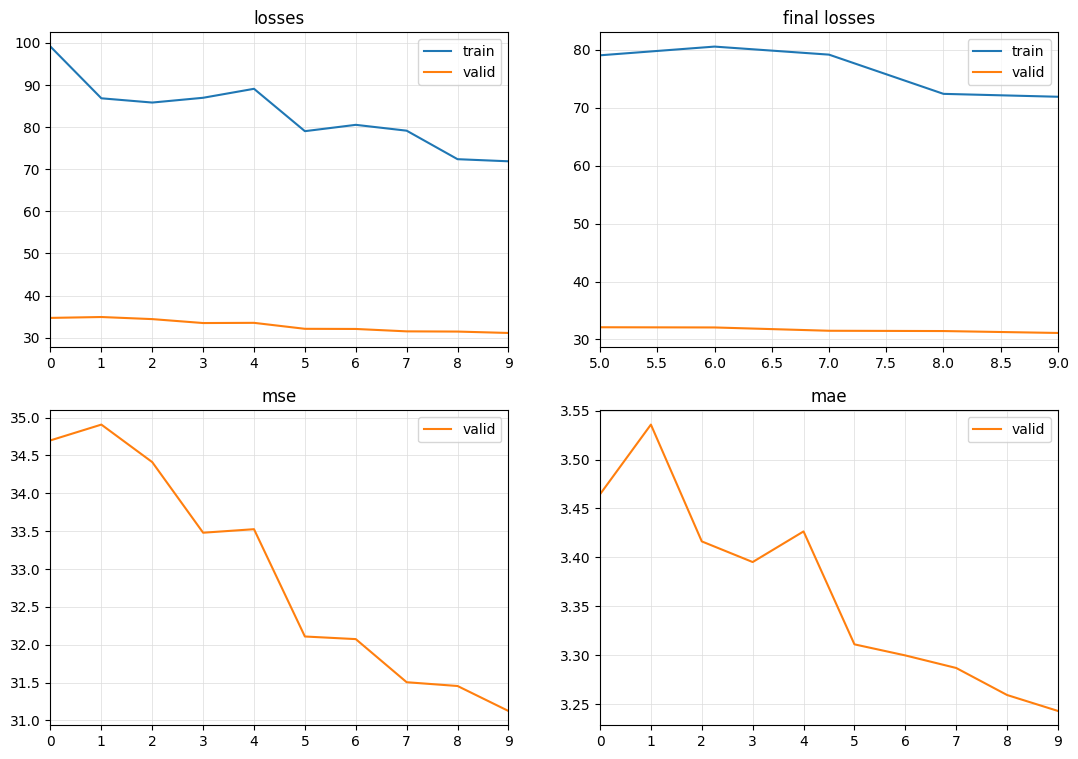

In [22]:
learn.fit_one_cycle(n_epoch=config.n_epoch, lr_max=lr_max)
learn.export('patchTST.pt')

### Evaluation

In [23]:
from tsai.inference import load_learner
from sklearn.metrics import mean_squared_error, mean_absolute_error

y_test = y[splits[2]]
learn = load_learner('models/patchTST.pt')
y_test_preds, *_ = learn.get_X_preds(X[splits[2]])
y_test_preds = to_np(y_test_preds)
print(f"y_test_preds.shape: {y_test_preds.shape}")     

y_test_preds.shape: (1912, 4, 6)


In [24]:
#| export

# The forecast error is defined as the difference  between the forecasted value 
# and the actual value. It is also dependant on the time, i.e., on the horizon 
# of the forecast (h).
# NOTE: This function computes the error for just one variable, not for all of them
def forecast_error(y_true, y_pred, h):
    # y_true: actual values (samples x steps)
    # y_pred: predicted values (samples x steps)
    # h: horizon of the forecast (1..horizon)
    return (y_pred[:, h-1] - y_true[:, h-1])

# forecast error normalized by the actual value
def percent_forecast_error(y_true, y_pred, h):
    # y_true: actual values (samples x steps)
    # y_pred: predicted values (samples x steps)
    # h: horizon of the forecast (1..horizon)
    return 100*(forecast_error(y_true, y_pred, h) / y_true[:, h-1])

In [25]:
# Test
print(y_test.shape, 
      forecast_error(y_test[:,0,:], y_test_preds[:,0,:], 6).shape,
      percent_forecast_error(y_test[:,0,:], y_test_preds[:,0,:], 6).shape)

(1912, 4, 6) (1912,) (1912,)


The evaluation is done for each variable separately, for each solar activity 
level (low, moderate, elevated and high), as in the paper by Licata et al. (2020)
Therefore, the test set has to be split into 4 different sets, one for each solar activity level. The thresholds for each solar activity level are the same as in the paper by Licata et al. (2020)

The thresholds are:
- F10: 75, 150, 190
- S10: 65, 150, 215
- M10: 72, 144, 167
- Y10: 81, 148, 165

In [26]:
#|export

def get_idxs_per_solar_activity_level(data, thresholds):
    # function that splits the data of a variable into 4 different sets, 
    # one for each solar activity level. The data comes as a numpy array with 
    # shape (samples, steps), and the split is done along the samples axis. 
    # The decision is made based on the first column of each sample. The function 
    # returns a list of 4 numpy arrays, one for each solar activity level. 
    # But it does not return the values, it returns the indices of the
    # samples that belong to each solar activity level.
    idxs_per_solar_activity_level = []
    for i in range(len(thresholds) + 1):
        if i == 0:
            idxs = np.where(data[:, 0] <= thresholds[i])[0]
        elif i == len(thresholds):
            idxs = np.where(data[:, 0] > thresholds[i-1])[0]
        else:
            idxs = np.where((data[:, 0] > thresholds[i-1]) & (data[:, 0] <= thresholds[i]))[0]
        idxs_per_solar_activity_level.append(idxs)
    return idxs_per_solar_activity_level

In [27]:
# Call the function for each variable, using y_test
thresholds = {'F10': [75, 150, 190], 
              'S10': [65, 150, 215], 
              'M10': [72, 144, 167], 
              'Y10': [81, 148, 165]}

y_test_split_idxs = {}
for i, var in enumerate(data_columns):
    y_test_split_idxs[var] = get_idxs_per_solar_activity_level(y_test[:, i, :], 
                                                               thresholds[var])
# Check the shape of each variable
for var in data_columns:
    print(f"{var}: {[y_test_split_idxs[var][i].shape for i in range(4)]}")

F10: [(246,), (1436,), (207,), (23,)]
S10: [(139,), (1485,), (288,), (0,)]
M10: [(225,), (1418,), (239,), (30,)]
Y10: [(127,), (1684,), (97,), (4,)]


In [28]:
# Now split y_test and y_test_preds with the idxs we got, using numpy.take
y_test_split = {}
y_test_preds_split = {}
for var in data_columns:
    y_test_split[var] = [y_test[:, i, :].take(y_test_split_idxs[var][i], axis=0) for i in range(4)]
    y_test_preds_split[var] = [y_test_preds[:, i, :].take(y_test_split_idxs[var][i], axis=0) for i in range(4)]

# Check the shape of each variable in y_test_split
for var in data_columns:
    print(f"y_test-{var}: {[y_test_split[var][i].shape for i in range(4)]}")
    print(f"y_test_preds-{var}: {[y_test_preds_split[var][i].shape for i in range(4)]}")

y_test-F10: [(246, 6), (1436, 6), (207, 6), (23, 6)]
y_test_preds-F10: [(246, 6), (1436, 6), (207, 6), (23, 6)]
y_test-S10: [(139, 6), (1485, 6), (288, 6), (0, 6)]
y_test_preds-S10: [(139, 6), (1485, 6), (288, 6), (0, 6)]
y_test-M10: [(225, 6), (1418, 6), (239, 6), (30, 6)]
y_test_preds-M10: [(225, 6), (1418, 6), (239, 6), (30, 6)]
y_test-Y10: [(127, 6), (1684, 6), (97, 6), (4, 6)]
y_test_preds-Y10: [(127, 6), (1684, 6), (97, 6), (4, 6)]


In [29]:
# Create a table (dataframe) with the mean forecast error for each variable (F10, S10, M10, Y10), 
# each solar activity level and each horizon (1..horizon)
data = []
sals = ['low', 'moderate', 'elevated', 'high']
for var_idx, var in enumerate(data_columns):
    for sal_idx,sal in enumerate(sals):
        for h in range(1, horizon+1):
            fe_sfu = forecast_error(y_test_split[var][sal_idx], 
                                y_test_preds_split[var][sal_idx], h)
            fe_percent = percent_forecast_error(y_test_split[var][sal_idx],
                                            y_test_preds_split[var][sal_idx], h)
            n_samples = y_test_split[var][sal_idx].shape[0]
            data.append([var, sal, h, np.mean(fe_sfu), np.std(fe_sfu), 
                        np.mean(fe_percent), np.std(fe_percent), n_samples])
df_results = pd.DataFrame(data, columns=['variable', 'condition', 'horizon', 
                                         'µ_sfu', 'σ_sfu', 'µ_percent', 'σ_percent', 'n_samples'])
df_results.head(10)

,variable,condition,horizon,µ_sfu,σ_sfu,µ_percent,σ_percent,n_samples
0,F10,low,1,0.310666,1.428460,0.435738,1.965600,246
1,F10,low,2,0.324664,1.933390,0.475987,2.632825,246
2,F10,low,3,0.414712,2.645363,0.633635,3.546103,246
3,F10,low,4,0.505872,3.419891,0.810817,4.521276,246
4,F10,low,5,0.443349,4.179204,0.801428,5.397777,246
5,F10,low,6,0.351212,4.935278,0.761434,6.207367,246
6,F10,moderate,1,0.313549,2.740657,0.300092,2.322992,1436
7,F10,moderate,2,0.306875,4.263290,0.361831,3.581925,1436
8,F10,moderate,3,0.324644,5.664443,0.470853,4.735112,1436
9,F10,moderate,4,0.341492,6.973899,0.599109,5.802150,1436


In [30]:
# Divide the table into one dataframe for each variable, and print it in a way
# that has the same format as the table in the paper, that is:
# Columns: | Condition | Statistics | 1 Day | 2 Days | 3 Days | ... | {{horizon}} Days,
# where condition is the variable and the solar activity level, and statistics 
# is the mean (column mean_fe) and the standard deviation (std_fe) of the forecast error.
for var in data_columns:
    df_var = df_results[df_results['variable'] == var].drop(columns=['variable', 
                                                                     'µ_percent', 
                                                                     'σ_percent'])
    df_var = df_var.melt(id_vars=['condition', 'horizon'], 
                         value_vars=['µ_sfu', 'σ_sfu'], 
                         var_name='Statistic')
    # Sort the values of the column condition so that the order is 
    # low, moderate, elevated, high
    df_var['condition'] = pd.Categorical(df_var['condition'], 
                                      categories=['low', 'moderate', 'elevated', 'high'], 
                                      ordered=True)
    df_var = df_var.pivot_table(index=['condition', 'Statistic'], 
                          columns='horizon', 
                          values='value')
    # pretty print, and separate with a blank line
    print(df_var.to_string(), '\n')


horizon                     1         2         3          4          5          6
condition Statistic                                                               
low       µ_sfu      0.310666  0.324664  0.414712   0.505872   0.443349   0.351212
          σ_sfu      1.428460  1.933390  2.645363   3.419891   4.179204   4.935278
moderate  µ_sfu      0.313549  0.306875  0.324644   0.341492   0.278872   0.210977
          σ_sfu      2.740657  4.263290  5.664443   6.973899   8.189357   9.163018
elevated  µ_sfu     -1.086812 -1.944081 -2.391297  -2.549662  -2.267542  -1.832885
          σ_sfu      3.779601  6.091077  8.655733  10.563381  12.129615  13.021819
high      µ_sfu     -1.531140 -2.242293 -3.469187  -3.983742  -3.067308  -1.324972
          σ_sfu      3.430712  4.296255  4.858794   6.313869   8.016966   9.403820 

horizon                     1         2         3          4          5          6
condition Statistic                                                               
lo

### Visualize predictions

In [31]:
dtms = prepare_forecasting_data(df.reset_index(), fcst_history=lookback, 
                                fcst_horizon=horizon, x_vars='Date', y_vars='Date')
dtms = np.concatenate((dtms[0], dtms[1]), axis=2).squeeze(axis=1)
dtms.shape

(9484, 42)

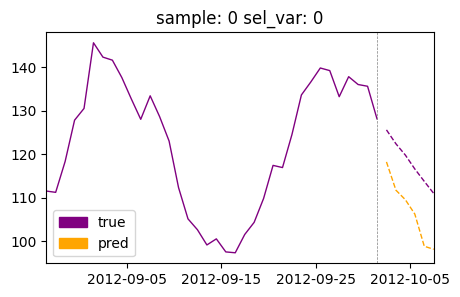

In [32]:
X_test = X[splits[2]]
y_test = y[splits[2]]
dtms_test = dtms[splits[2]]
plot_forecast_2(X_test, y_test, y_test_preds, dtms=dtms_test, sel_vars=0, idx=0, 
                figsize=(5,3), n_samples=1)

In [33]:
def plot_solar_algorithm_performance(df, var, figsize=(10, 10), ylims_mean=None, ylims_std=None):
    # Plot a grid where each row is a solar activity level, and each column
    # is a error type (sfu or percent). Each cell is the result of calling the 
    # function plot_fe.
    # Input:
    # df: dataframe with the results of the forecasting experiment, with the columns
    #     variable, condition, horizon, µ_sfu, σ_sfu, µ_percent, σ_percent
    # var: variable to plot (F10, S10, M10, Y10)
    # figsize: figure size
    # ylims_mean: List with the y limits of the mean for each error type: 
    #   [(percent[0], percent[1]), (sfu[0], sfu[1])]
    # ylims_std: List with the y limits of the standard deviation for each error type:
    #   [(percent[0], percent[1]), (sfu[0], sfu[1])]
    # Output:
    # None, but it plots the grid
    sals = ['low', 'moderate', 'elevated', 'high']
    fig, axs = plt.subplots(len(sals), 2, figsize=figsize)
    fig.suptitle(f"Forecast error for {var}")
    for sal_idx, sal in enumerate(sals):
        for idx, err_type in enumerate(['percent', 'sfu']):
            df_var = df[(df['variable'] == var) & (df['condition'] == sal)]
            # Minimum and maximum values across column
            min_val_mean = df[f'µ_{err_type}'].min() if ylims_mean is None else ylims_mean[idx][0]
            max_val_mean = df[f'µ_{err_type}'].max() if ylims_mean is None else ylims_mean[idx][1]
            min_val_std = df[f'σ_{err_type}'].min() if ylims_std is None else ylims_std[idx][0]
            max_val_std = df[f'σ_{err_type}'].max() if ylims_std is None else ylims_std[idx][1]

            mean_fe = df_var[f'µ_{err_type}'].values
            std_fe = df_var[f'σ_{err_type}'].values
            ax = axs[sal_idx, idx]
            ax.plot(mean_fe, color='#000000')
            ax.set_xlabel('Days from Epoch')
            ax.set_ylabel(f'Mean [{err_type}]', color='#000000')
            ax.tick_params(axis='y', labelcolor='#000000')
            ax.set_xticks(range(len(mean_fe)))
            ax.set_xticklabels(range(1, len(mean_fe)+1))
            ax.set_ylim(min_val_mean, max_val_mean)
            ax2 = ax.twinx()
            ax2.plot(std_fe, color='tab:red')
            ax2.set_ylabel(f'STD [{err_type}]', color='tab:red')
            ax2.set_ylim(min_val_std, max_val_std)
            ax2.tick_params(axis='y', labelcolor='tab:red')
            # ax2.set_xticks(range(len(std_fe)))
            # ax2.set_xticklabels(range(1, len(std_fe)+1))
            n_samples = df_var['n_samples'].values[0] 
            ax.set_title(f'{sal}\n{n_samples} forecasts')
            # Draw a grid in the background
            ax.grid(True, which='both', axis='both', color='lightgrey',
                    linestyle='-', linewidth=0.5)
            fig.tight_layout()

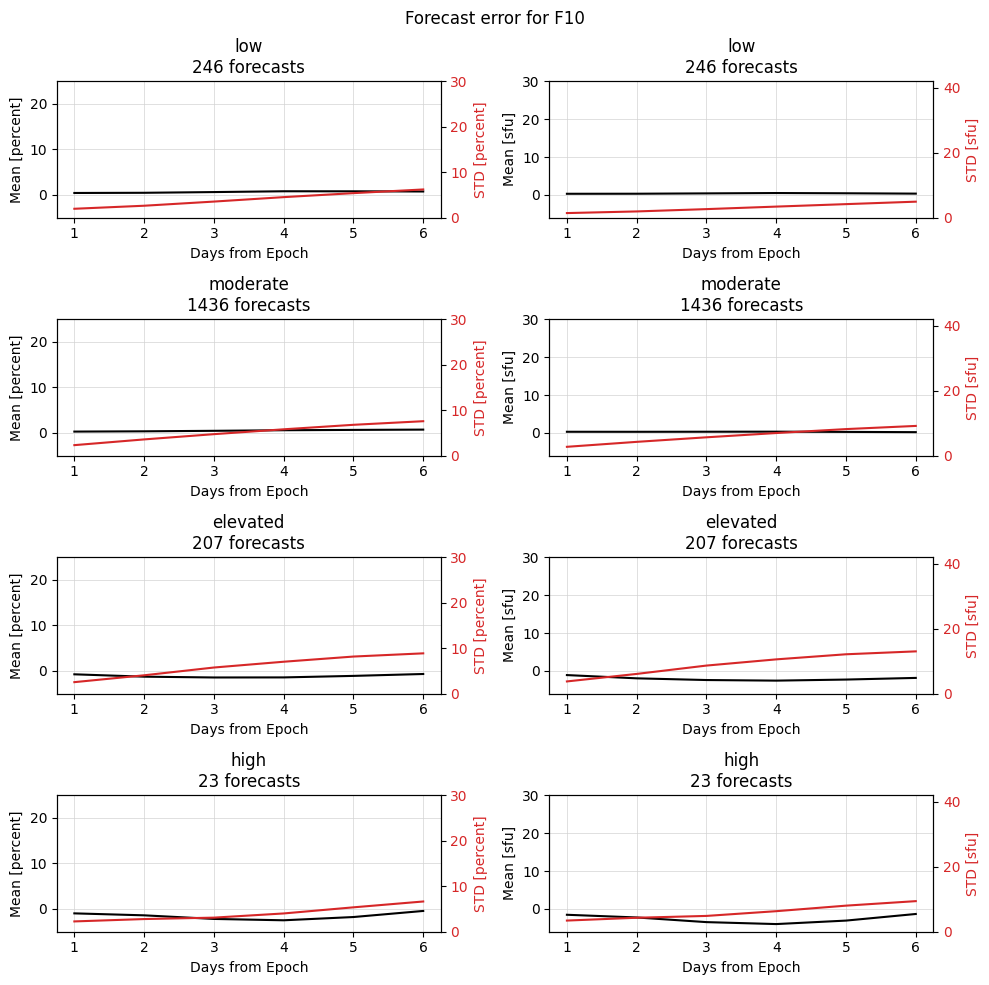

In [34]:
plot_solar_algorithm_performance(df_results, 'F10', ylims_mean=[(-5, 25), (-6, 30)],
                                 ylims_std=[(0, 30), (0, 42)])

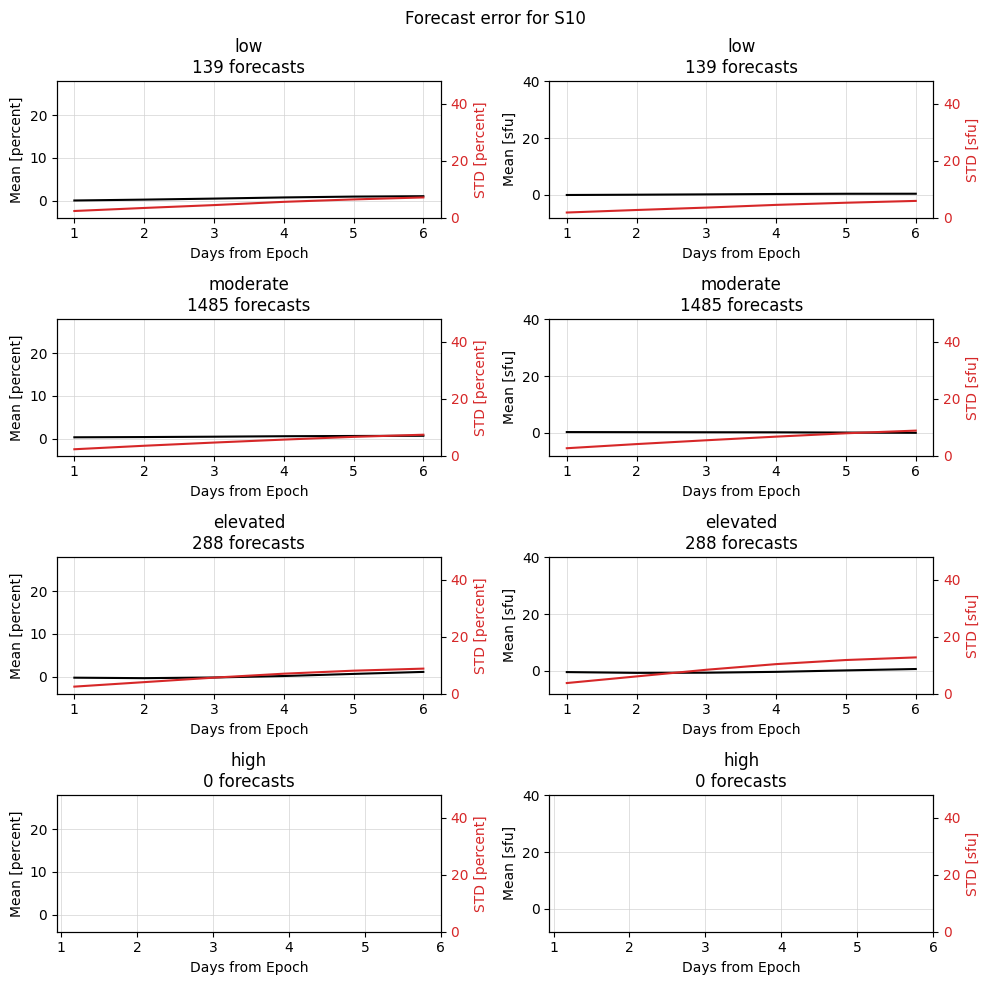

In [35]:
plot_solar_algorithm_performance(df_results, 'S10', ylims_mean=[(-4, 28), (-8, 40)],
                                 ylims_std=[(0, 48), (0, 48)])

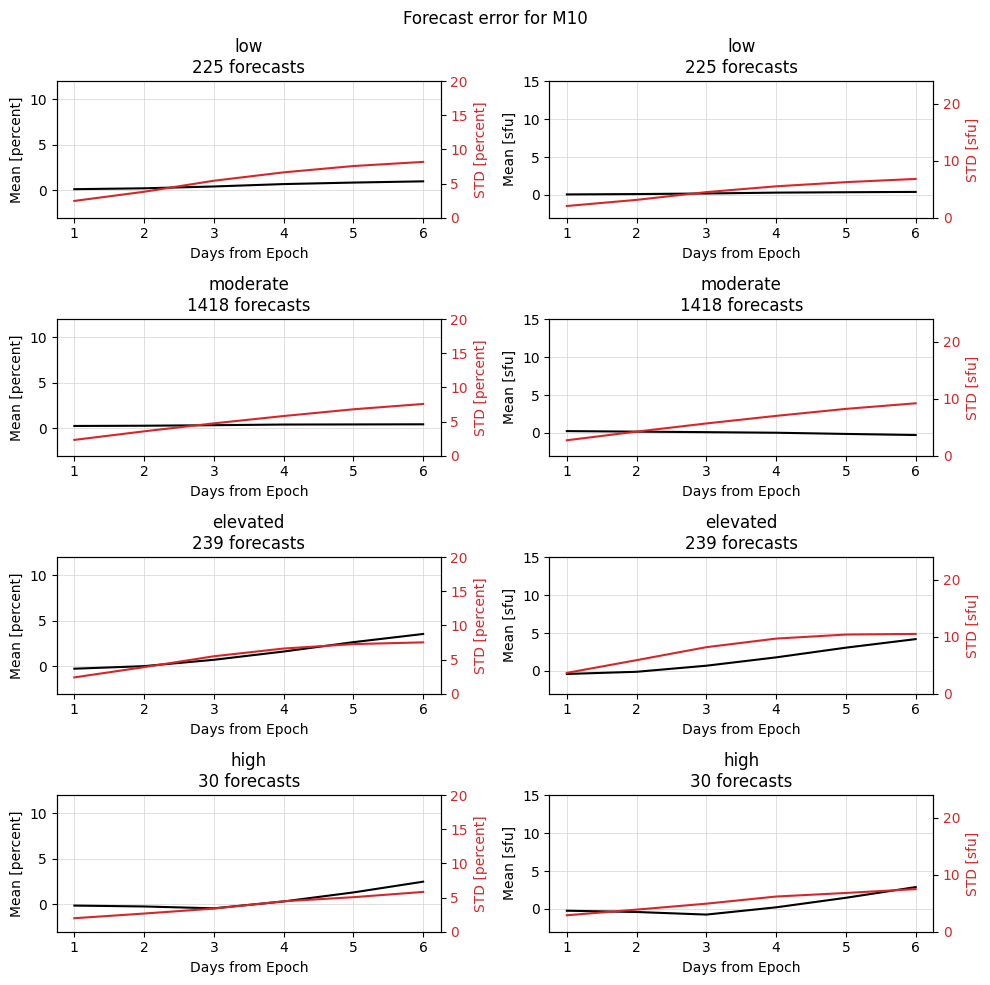

In [36]:
plot_solar_algorithm_performance(df_results, 'M10', ylims_mean=[(-3, 12), (-3, 15)],
                                 ylims_std=[(0, 20), (0, 24)])

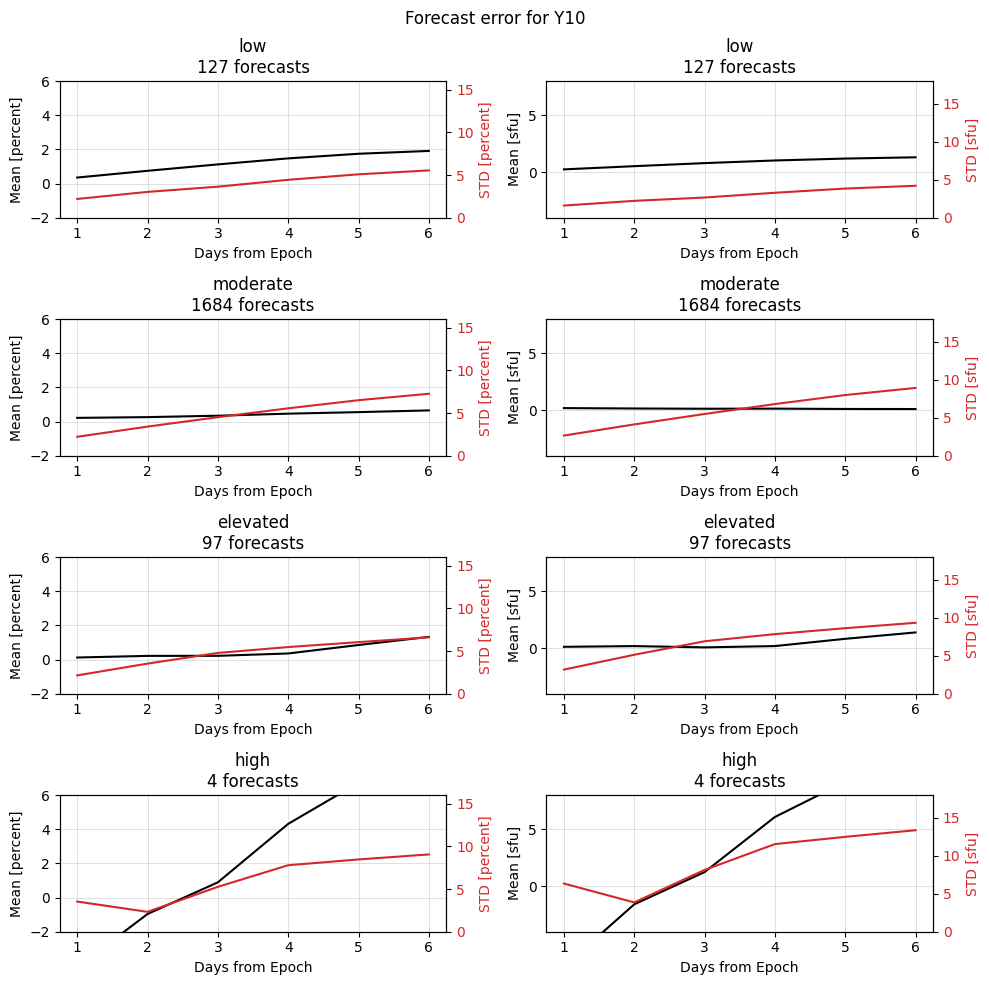

In [37]:
plot_solar_algorithm_performance(df_results, 'Y10', ylims_mean=[(-2, 6), (-4, 8)],
                                 ylims_std=[(0, 16), (0, 18)])